In [47]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import acquire
import titanic_prep
import telco_prep
import warnings as warn
warn.filterwarnings("ignore")
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer



In [2]:
titanic_df = acquire.get_titanic_data()

titanic_df.head()

,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [3]:

titanic_df = titanic_df.drop_duplicates()
titanic_df = titanic_df.drop(columns=['deck', 'embarked', 'class', 'passenger_id', 'Unnamed: 0'])
titanic_df['embark_town'] = titanic_df.embark_town.fillna(value='Southampton')
dummy_df = pd.get_dummies(titanic_df[['sex', 'embark_town']], drop_first=True)
titanic_df = pd.concat([titanic_df, dummy_df], axis=1)

In [4]:
titanic_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,3,male,22.0,1,0,7.2500,Southampton,0,1,0,1
1,1,1,female,38.0,1,0,71.2833,Cherbourg,0,0,0,0
2,1,3,female,26.0,0,0,7.9250,Southampton,1,0,0,1
3,1,1,female,35.0,1,0,53.1000,Southampton,0,0,0,1
4,0,3,male,35.0,0,0,8.0500,Southampton,1,1,0,1


In [5]:

titanic_train, titanic_test = train_test_split(titanic_df, test_size=.2, random_state=123, stratify=titanic_df.survived)
titanic_train, titanic_validate = train_test_split(titanic_train, test_size=.3, random_state=123, stratify=titanic_train.survived)

# Validate my split

print(f'train -> {titanic_train.shape}')
print(f'validate -> {titanic_validate.shape}')
print(f'test -> {titanic_test.shape}')


train -> (498, 12)
validate -> (214, 12)
test -> (179, 12)


In [6]:
imputer = SimpleImputer(missing_values = None, strategy='most_frequent')

imputer = imputer.fit(titanic_train[['embark_town']])


In [7]:
titanic_train[['embark_town']] = imputer.transform(titanic_train[['embark_town']])

titanic_validate[['embark_town']] = imputer.transform(titanic_validate[['embark_town']])

titanic_test[['embark_town']] = imputer.transform(titanic_test[['embark_town']])


In [40]:

titanic_train.embark_town.value_counts(dropna=False)

titanic_train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
583,0,1,male,36.0,0,0,40.1250,Cherbourg,1,1,0,0
165,1,3,male,9.0,0,2,20.5250,Southampton,0,1,0,1
50,0,3,male,7.0,4,1,39.6875,Southampton,0,1,0,1
259,1,2,female,50.0,0,1,26.0000,Southampton,0,0,0,1
306,1,1,female,NaN,0,0,110.8833,Cherbourg,1,0,0,0


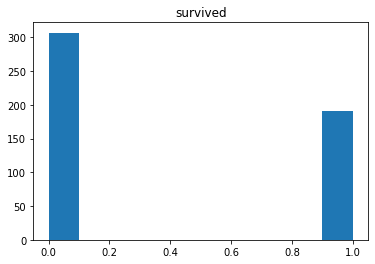

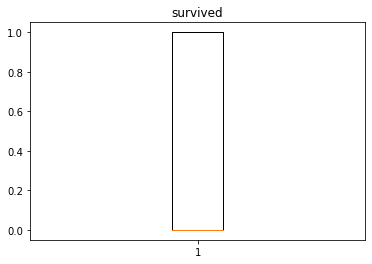

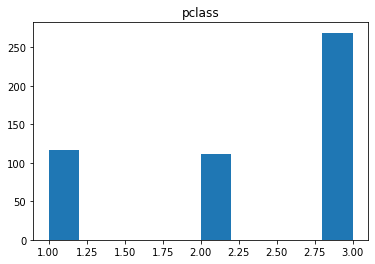

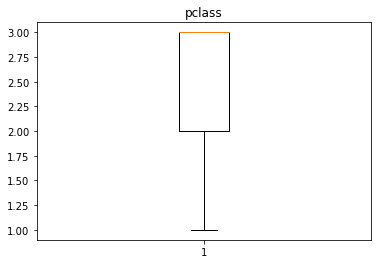

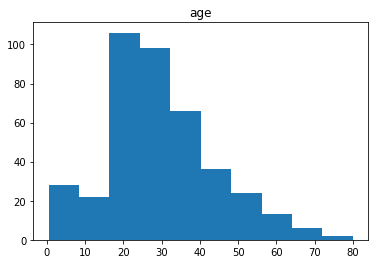

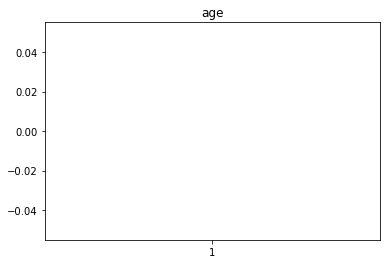

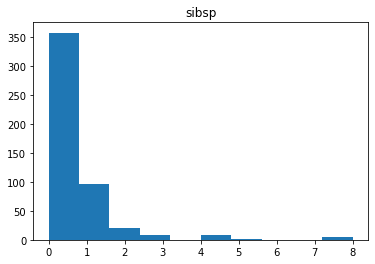

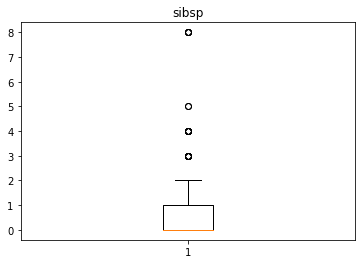

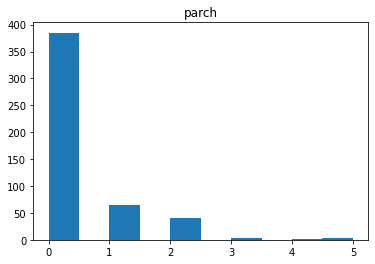

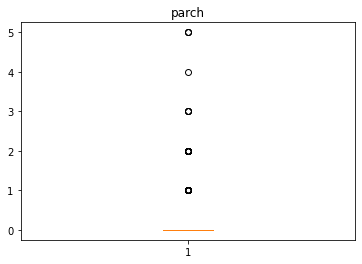

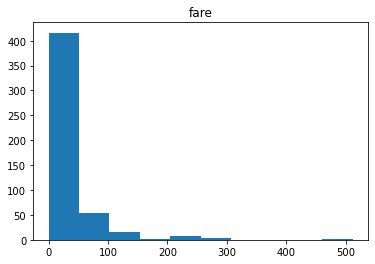

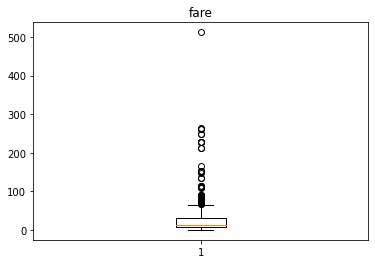

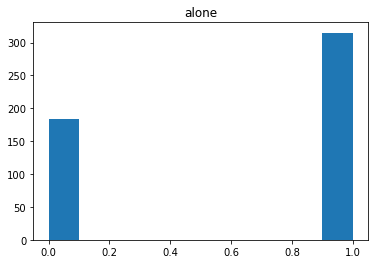

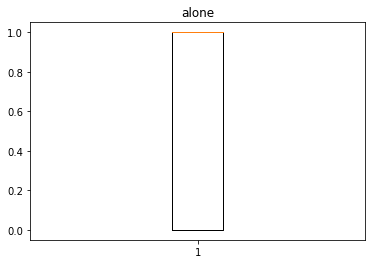

In [9]:
num_cols = titanic_train.columns[[(titanic_train[col].dtype == 'int64') or (titanic_train[col].dtype == 'float64') for col in titanic_train.columns]]
for col in num_cols:
    plt.hist(titanic_train[col])
    plt.title(col)
    plt.show()
    plt.boxplot(titanic_train[col])
    plt.title(col)
    plt.show()

First graph shows that most passengers did not survive

We can see by the class chart that the majority were in 3rd class with not much difference between 1st and 2nd

the age chart shows that we see most the passengers were in their 20s and drops off both sides, not quite normal distributions

The sibling chart shows a few outliers but the majority did not have siblings on the ship, the same can be applied for parents with children

Fare graph shows the vast majority paid under 50 with the second most popular tickets being under 100 

The last graph shows that more than half the passengers were traveling alone. 

In [10]:
titanic_train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
583,0,1,male,36.0,0,0,40.1250,Cherbourg,1,1,0,0
165,1,3,male,9.0,0,2,20.5250,Southampton,0,1,0,1
50,0,3,male,7.0,4,1,39.6875,Southampton,0,1,0,1
259,1,2,female,50.0,0,1,26.0000,Southampton,0,0,0,1
306,1,1,female,NaN,0,0,110.8833,Cherbourg,1,0,0,0


Below I will graph a few variables against survival rate to find any relationships between the two

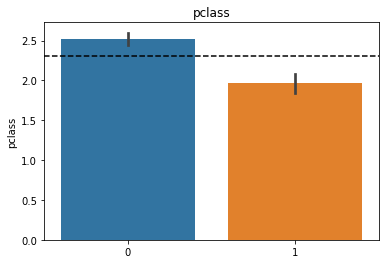

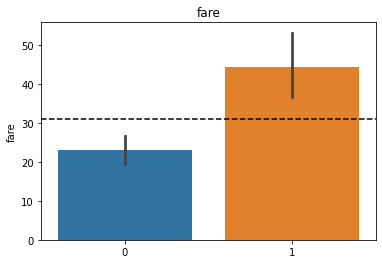

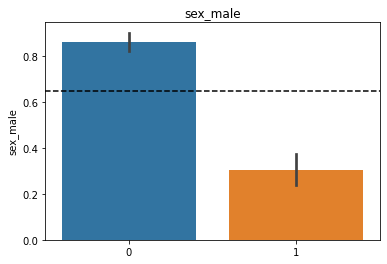

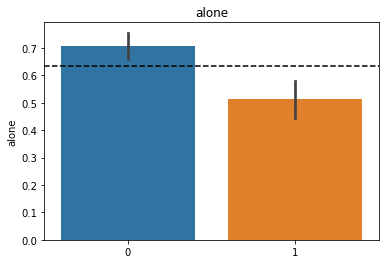

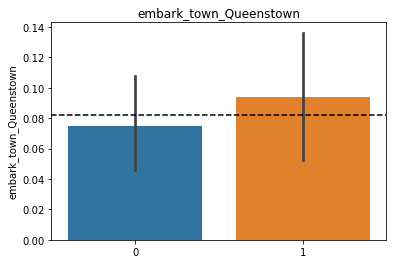

In [11]:
variables = ['pclass','fare','sex_male', 'alone', 'embark_town_Queenstown', 'age']

mean = [titanic_train['pclass'].mean(), titanic_train['fare'].mean(), titanic_train['sex_male'].mean(), titanic_train['alone'].mean(), titanic_train['embark_town_Queenstown'].mean(), titanic_train['age'].mean()]

for x in range(0,5):
    sns.barplot('survived',variables[x], data=titanic_train)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()

### Model Exercises

What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

Baseline prediction is not survived becuase it is the most common with a baseline accuracy of 61.6%

In [8]:
titanic_df.isnull().sum()

survived                     0
pclass                       0
sex                          0
age                        177
sibsp                        0
parch                        0
fare                         0
embark_town                  0
alone                        0
sex_male                     0
embark_town_Queenstown       0
embark_town_Southampton      0
dtype: int64

In [10]:
titanic_train['survived'].value_counts(), titanic_train.shape

(0    307
 1    191
 Name: survived, dtype: int64,
 (498, 12))

In [11]:
baseline_pred = 307 / 498

baseline_pred

titanic_train['baseline'] = 0

## Baseline prediction is 61.6% and made the baseline column set to zero

Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [14]:
x_vars = ['pclass','fare','sex_male', 'alone']
y_vars = 'survived'

X_train, y_train = titanic_train[x_vars], titanic_train[y_vars]
x_validate, y_validate = titanic_validate[x_vars], titanic_validate[y_vars]
x_test, y_test = titanic_test[x_vars], titanic_test[y_vars]

In [16]:
x_validate.shape, y_validate.shape

((214, 4), (214,))

In [17]:
tree = DecisionTreeClassifier(max_depth=3, random_state=100)

In [19]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=100)

[Text(0.5, 0.875, 'sex_male <= 0.5\ngini = 0.473\nsamples = 498\nvalue = [307, 191]\nclass = Died'),
 Text(0.25, 0.625, 'pclass <= 2.5\ngini = 0.365\nsamples = 175\nvalue = [42, 133]\nclass = survived'),
 Text(0.125, 0.375, 'fare <= 28.856\ngini = 0.081\nsamples = 94\nvalue = [4, 90]\nclass = survived'),
 Text(0.0625, 0.125, 'gini = 0.133\nsamples = 42\nvalue = [3, 39]\nclass = survived'),
 Text(0.1875, 0.125, 'gini = 0.038\nsamples = 52\nvalue = [1, 51]\nclass = survived'),
 Text(0.375, 0.375, 'fare <= 23.912\ngini = 0.498\nsamples = 81\nvalue = [38, 43]\nclass = survived'),
 Text(0.3125, 0.125, 'gini = 0.476\nsamples = 69\nvalue = [27, 42]\nclass = survived'),
 Text(0.4375, 0.125, 'gini = 0.153\nsamples = 12\nvalue = [11, 1]\nclass = Died'),
 Text(0.75, 0.625, 'fare <= 18.275\ngini = 0.295\nsamples = 323\nvalue = [265, 58]\nclass = Died'),
 Text(0.625, 0.375, 'alone <= 0.5\ngini = 0.184\nsamples = 205\nvalue = [184, 21]\nclass = Died'),
 Text(0.5625, 0.125, 'gini = 0.32\nsamples = 20

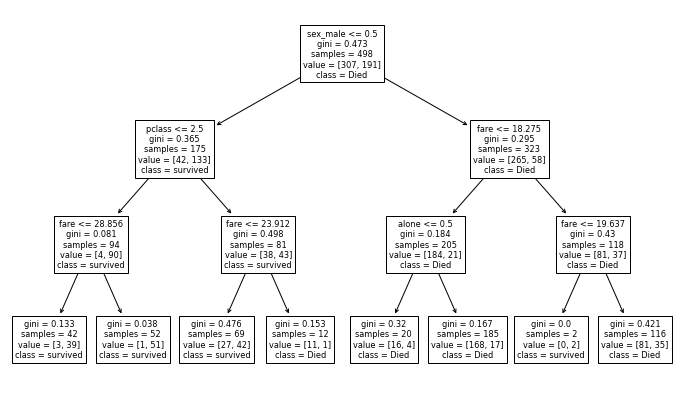

In [20]:
plt.figure(figsize=(12, 7))
plot_tree(tree, feature_names=X_train.columns, class_names=['Died', 'survived'])

In [21]:
# make prediction on train obeservations

y_pred = tree.predict(X_train)
y_pred[0:5]


array([0, 0, 0, 1, 1])

In [22]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(tree.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.82


In [23]:
# confusion matrix

confusion_matrix(y_train, y_pred)


array([[276,  31],
       [ 57, 134]])

In [24]:
y_train.value_counts()

print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.90      0.86       307
           1       0.81      0.70      0.75       191

    accuracy                           0.82       498
   macro avg       0.82      0.80      0.81       498
weighted avg       0.82      0.82      0.82       498



In [69]:
x_validate.shape, y_validate.shape

((214, 4), (179,))

In [25]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(tree.score(x_validate, y_validate)))


Accuracy of Decision Tree classifier on validate set: 0.79


## Same tree model but with different max depth

In [26]:
tree2 = DecisionTreeClassifier(max_depth=4, random_state=100)

In [27]:
tree2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=100)

[Text(0.5446428571428571, 0.9, 'sex_male <= 0.5\ngini = 0.473\nsamples = 498\nvalue = [307, 191]\nclass = Died'),
 Text(0.2857142857142857, 0.7, 'pclass <= 2.5\ngini = 0.365\nsamples = 175\nvalue = [42, 133]\nclass = survived'),
 Text(0.14285714285714285, 0.5, 'fare <= 28.856\ngini = 0.081\nsamples = 94\nvalue = [4, 90]\nclass = survived'),
 Text(0.07142857142857142, 0.3, 'fare <= 28.231\ngini = 0.133\nsamples = 42\nvalue = [3, 39]\nclass = survived'),
 Text(0.03571428571428571, 0.1, 'gini = 0.093\nsamples = 41\nvalue = [2, 39]\nclass = survived'),
 Text(0.10714285714285714, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Died'),
 Text(0.21428571428571427, 0.3, 'fare <= 149.035\ngini = 0.038\nsamples = 52\nvalue = [1, 51]\nclass = survived'),
 Text(0.17857142857142858, 0.1, 'gini = 0.0\nsamples = 41\nvalue = [0, 41]\nclass = survived'),
 Text(0.25, 0.1, 'gini = 0.165\nsamples = 11\nvalue = [1, 10]\nclass = survived'),
 Text(0.42857142857142855, 0.5, 'fare <= 23.912\ngini = 0.498

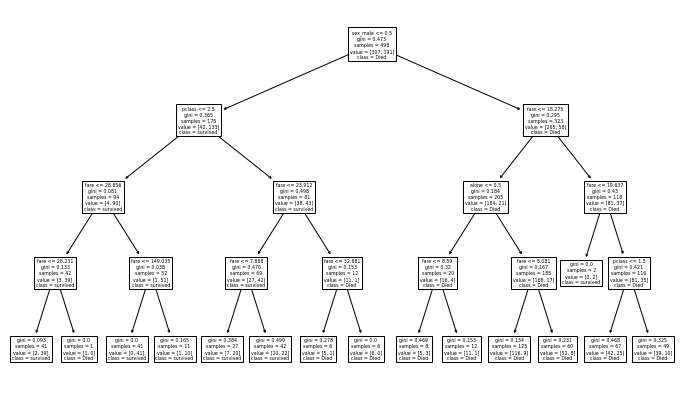

In [28]:
plt.figure(figsize=(12, 7))
plot_tree(tree2, feature_names=X_train.columns, class_names=['Died', 'survived'])

In [29]:
# make prediction on train obeservations

y_pred2 = tree2.predict(X_train)
y_pred2[0:5]

array([0, 0, 0, 1, 1])

In [30]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(tree2.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.83


In [31]:
# confusion matrix

confusion_matrix(y_train, y_pred2)

array([[277,  30],
       [ 57, 134]])

In [32]:
print(classification_report(y_train, y_pred2))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       307
           1       0.82      0.70      0.75       191

    accuracy                           0.83       498
   macro avg       0.82      0.80      0.81       498
weighted avg       0.82      0.83      0.82       498



In [33]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(tree2.score(x_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.79


### Last tree model but with a shallower depth than the first

In [35]:
tree3 = DecisionTreeClassifier(max_depth=2, random_state=100)

In [36]:
tree3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=100)

[Text(0.5, 0.8333333333333334, 'sex_male <= 0.5\ngini = 0.473\nsamples = 498\nvalue = [307, 191]\nclass = died'),
 Text(0.25, 0.5, 'pclass <= 2.5\ngini = 0.365\nsamples = 175\nvalue = [42, 133]\nclass = survived'),
 Text(0.125, 0.16666666666666666, 'gini = 0.081\nsamples = 94\nvalue = [4, 90]\nclass = survived'),
 Text(0.375, 0.16666666666666666, 'gini = 0.498\nsamples = 81\nvalue = [38, 43]\nclass = survived'),
 Text(0.75, 0.5, 'fare <= 18.275\ngini = 0.295\nsamples = 323\nvalue = [265, 58]\nclass = died'),
 Text(0.625, 0.16666666666666666, 'gini = 0.184\nsamples = 205\nvalue = [184, 21]\nclass = died'),
 Text(0.875, 0.16666666666666666, 'gini = 0.43\nsamples = 118\nvalue = [81, 37]\nclass = died')]

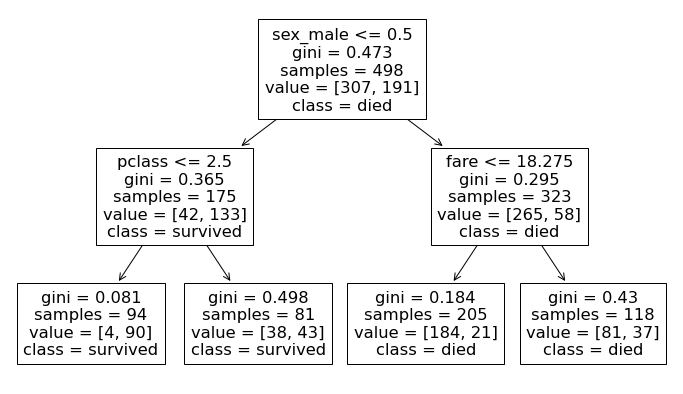

In [37]:
plt.figure(figsize=(12, 7))
plot_tree(tree3, feature_names=X_train.columns, class_names=['died', 'survived'])

In [38]:
y_pred3 = tree3.predict(X_train)
y_pred3[0:5]

array([0, 0, 0, 1, 1])

In [39]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(tree3.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


In [40]:
# confusion matrix

confusion_matrix(y_train, y_pred3)

array([[265,  42],
       [ 58, 133]])

In [41]:
print(classification_report(y_train, y_pred3
))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       307
           1       0.76      0.70      0.73       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498



In [44]:
print('Accuracy of Decision Tree 1 classifier on validate set: {:.2f}'
     .format(tree.score(x_validate, y_validate)))

print('Accuracy of Decision Tree 2 classifier on validate set: {:.2f}'
     .format(tree2.score(x_validate, y_validate)))

print('Accuracy of Decision Tree 3 classifier on validate set: {:.2f}'
     .format(tree3.score(x_validate, y_validate)))

Accuracy of Decision Tree 1 classifier on validate set: 0.79
Accuracy of Decision Tree 2 classifier on validate set: 0.79
Accuracy of Decision Tree 3 classifier on validate set: 0.76


Tree 1 done the best with validate even though it has the same accuracy. It is the best because it uses a smaller tree compared to tree 2. Tree 2 was the best for the training data

### Telco Model

In [95]:
telco_df = acquire.get_telco_data()

telco_df.columns

Index(['Unnamed: 0', 'internet_service_type_id', 'payment_type_id',
       'contract_type_id', 'customer_id', 'gender', 'senior_citizen',
       'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'paperless_billing',
       'monthly_charges', 'total_charges', 'churn', 'contract_type',
       'payment_type', 'internet_service_type'],
      dtype='object')

In [48]:
telco_train, telco_validate, telco_test = telco_prep.prep_telco_data(telco_df)

In [49]:
print(f'train -> {telco_train.shape}')
print(f'validate -> {telco_validate.shape}')
print(f'test -> {telco_test.shape}')

train -> (4500, 47)
validate -> (1125, 47)
test -> (1407, 47)


In [97]:
telco_train.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'contract_type', 'payment_type', 'internet_service_type',
       'gender_encoded', 'partner_encoded', 'dependents_encoded',
       'phone_service_encoded', 'paperless_billing_encoded', 'churn_encoded',
       'multiple_lines_No phone service', 'multiple_lines_Yes',
       'online_security_No internet service', 'online_security_Yes',
       'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No internet service', 'device_protection_Yes',
       'tech_support_No internet service', 'tech_support_Yes',
       'streaming_tv_No internet service', 'streaming_tv_Yes',
       'streaming_movies_No internet service', 'streaming_movies_Yes',
       'contract_type_

# Finding Baseline predicition

In [52]:
telco_train['churn'].value_counts(), telco_train.shape

(No     3304
 Yes    1196
 Name: churn, dtype: int64,
 (4500, 47))

In [53]:
telco_baseline = 3304 / 4500

telco_baseline

# our baseline prediction is 73.42%

0.7342222222222222

In [98]:
x_vars = ['tenure','internet_service_type_Fiber optic','payment_type_Credit card (automatic)','payment_type_Electronic check','payment_type_Mailed check']
y_vars = 'churn'

x_train, y_train = telco_train[x_vars], telco_train[y_vars]
x_validate, y_validate = telco_validate[x_vars], telco_validate[y_vars]
x_test, y_test = telco_test[x_vars], telco_test[y_vars]

In [99]:
telco_tree = DecisionTreeClassifier(max_depth=3, random_state=100)

In [100]:
telco_tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=100)

[Text(0.5, 0.875, 'tenure <= 17.5\ngini = 0.39\nsamples = 4500\nvalue = [3304, 1196]\nclass = Churn'),
 Text(0.25, 0.625, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.496\nsamples = 1683\nvalue = [917, 766]\nclass = Churn'),
 Text(0.125, 0.375, 'tenure <= 3.5\ngini = 0.409\nsamples = 976\nvalue = [696, 280]\nclass = Churn'),
 Text(0.0625, 0.125, 'gini = 0.492\nsamples = 409\nvalue = [231, 178]\nclass = Churn'),
 Text(0.1875, 0.125, 'gini = 0.295\nsamples = 567\nvalue = [465, 102]\nclass = Churn'),
 Text(0.375, 0.375, 'tenure <= 1.5\ngini = 0.43\nsamples = 707\nvalue = [221, 486]\nclass = No Churn'),
 Text(0.3125, 0.125, 'gini = 0.245\nsamples = 154\nvalue = [22, 132]\nclass = No Churn'),
 Text(0.4375, 0.125, 'gini = 0.461\nsamples = 553\nvalue = [199, 354]\nclass = No Churn'),
 Text(0.75, 0.625, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.259\nsamples = 2817\nvalue = [2387, 430]\nclass = Churn'),
 Text(0.625, 0.375, 'tenure <= 57.5\ngini = 0.097\nsamples = 1552\nvalue = 

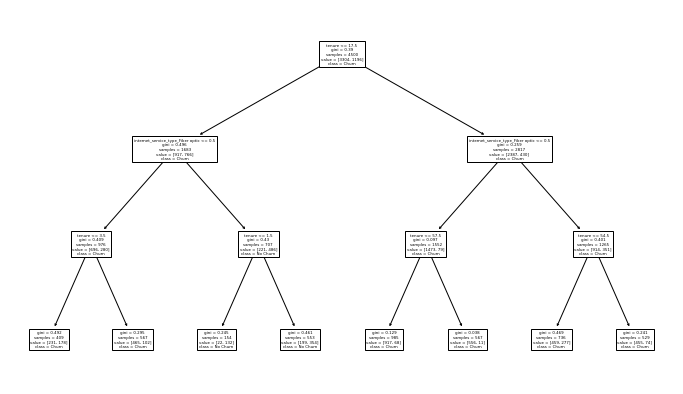

In [101]:
plt.figure(figsize=(12, 7))
plot_tree(telco_tree, feature_names=x_train.columns, class_names=['Churn', 'No Churn'])

In [102]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(telco_tree.score(x_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


We see a slightly better accuracy compared to the baseline

In [103]:
y_pred = telco_tree.predict(x_train)
y_pred[0:5]

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

In [104]:
confusion_matrix(y_train, y_pred)

array([[3083,  221],
       [ 710,  486]])

In [105]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.81      0.93      0.87      3304
         Yes       0.69      0.41      0.51      1196

    accuracy                           0.79      4500
   macro avg       0.75      0.67      0.69      4500
weighted avg       0.78      0.79      0.77      4500



# trying tree with more depth

In [106]:
telco_tree2 = DecisionTreeClassifier(max_depth=2, random_state=100)

In [107]:
telco_tree2.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=100)

[Text(0.5, 0.8333333333333334, 'tenure <= 17.5\ngini = 0.39\nsamples = 4500\nvalue = [3304, 1196]\nclass = Churn'),
 Text(0.25, 0.5, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.496\nsamples = 1683\nvalue = [917, 766]\nclass = Churn'),
 Text(0.125, 0.16666666666666666, 'gini = 0.409\nsamples = 976\nvalue = [696, 280]\nclass = Churn'),
 Text(0.375, 0.16666666666666666, 'gini = 0.43\nsamples = 707\nvalue = [221, 486]\nclass = No Churn'),
 Text(0.75, 0.5, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.259\nsamples = 2817\nvalue = [2387, 430]\nclass = Churn'),
 Text(0.625, 0.16666666666666666, 'gini = 0.097\nsamples = 1552\nvalue = [1473, 79]\nclass = Churn'),
 Text(0.875, 0.16666666666666666, 'gini = 0.401\nsamples = 1265\nvalue = [914, 351]\nclass = Churn')]

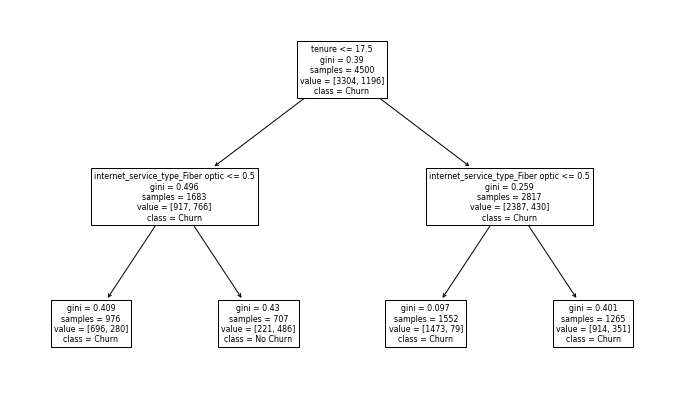

In [108]:
plt.figure(figsize=(12, 7))
plot_tree(telco_tree2, feature_names=x_train.columns, class_names=['Churn', 'No Churn'])

In [109]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(telco_tree2.score(x_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


In [110]:
y_pred2 = telco_tree2.predict(x_train)
y_pred[0:5]

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

In [111]:
confusion_matrix(y_train, y_pred2)

array([[3083,  221],
       [ 710,  486]])

In [112]:
print(classification_report(y_train, y_pred2))

              precision    recall  f1-score   support

          No       0.81      0.93      0.87      3304
         Yes       0.69      0.41      0.51      1196

    accuracy                           0.79      4500
   macro avg       0.75      0.67      0.69      4500
weighted avg       0.78      0.79      0.77      4500



# One more tree with more depth

In [113]:
telco_tree3 = DecisionTreeClassifier(max_depth=5, random_state=100)

In [114]:
telco_tree3.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=100)

[Text(0.4895833333333333, 0.9166666666666666, 'tenure <= 17.5\ngini = 0.39\nsamples = 4500\nvalue = [3304, 1196]\nclass = Churn'),
 Text(0.24583333333333332, 0.75, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.496\nsamples = 1683\nvalue = [917, 766]\nclass = Churn'),
 Text(0.13333333333333333, 0.5833333333333334, 'tenure <= 3.5\ngini = 0.409\nsamples = 976\nvalue = [696, 280]\nclass = Churn'),
 Text(0.06666666666666667, 0.4166666666666667, 'payment_type_Electronic check <= 0.5\ngini = 0.492\nsamples = 409\nvalue = [231, 178]\nclass = Churn'),
 Text(0.03333333333333333, 0.25, 'tenure <= 1.5\ngini = 0.467\nsamples = 283\nvalue = [178, 105]\nclass = Churn'),
 Text(0.016666666666666666, 0.08333333333333333, 'gini = 0.489\nsamples = 176\nvalue = [101, 75]\nclass = Churn'),
 Text(0.05, 0.08333333333333333, 'gini = 0.404\nsamples = 107\nvalue = [77, 30]\nclass = Churn'),
 Text(0.1, 0.25, 'tenure <= 1.5\ngini = 0.487\nsamples = 126\nvalue = [53, 73]\nclass = No Churn'),
 Text(0.083333333

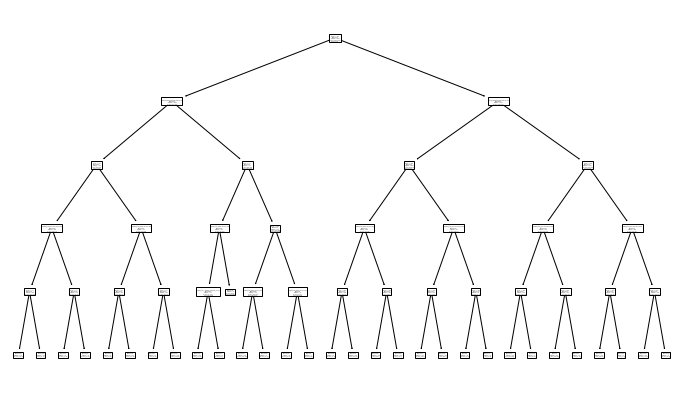

In [115]:
plt.figure(figsize=(12, 7))
plot_tree(telco_tree3, feature_names=x_train.columns, class_names=['Churn', 'No Churn'])

In [116]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(telco_tree3.score(x_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


In [117]:
y_pred3 = telco_tree3.predict(x_train)
y_pred3[0:5]

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

In [118]:
confusion_matrix(y_train, y_pred3)

array([[2901,  403],
       [ 505,  691]])

In [119]:
print(classification_report(y_train, y_pred3))

              precision    recall  f1-score   support

          No       0.85      0.88      0.86      3304
         Yes       0.63      0.58      0.60      1196

    accuracy                           0.80      4500
   macro avg       0.74      0.73      0.73      4500
weighted avg       0.79      0.80      0.80      4500



In [120]:
print('Accuracy of Decision Tree 1 classifier on validate set: {:.2f}'
     .format(telco_tree.score(x_validate, y_validate)))

print('Accuracy of Decision Tree 2 classifier on validate set: {:.2f}'
     .format(telco_tree2.score(x_validate, y_validate)))

print('Accuracy of Decision Tree 3 classifier on validate set: {:.2f}'
     .format(telco_tree3.score(x_validate, y_validate)))

Accuracy of Decision Tree 1 classifier on validate set: 0.77
Accuracy of Decision Tree 2 classifier on validate set: 0.77
Accuracy of Decision Tree 3 classifier on validate set: 0.77
